In [103]:
import h5py
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import json

In [104]:
fashiongen_h5 = h5py.File('/net/acadia10a/data/zkhan/fashion-gen/fashiongen_256_256_validation.h5', mode='r')

In [105]:
fashiongen_h5.keys()

<KeysViewHDF5 ['index', 'index_2', 'input_brand', 'input_category', 'input_composition', 'input_concat_description', 'input_department', 'input_description', 'input_gender', 'input_image', 'input_msrpUSD', 'input_name', 'input_pose', 'input_productID', 'input_season', 'input_subcategory']>

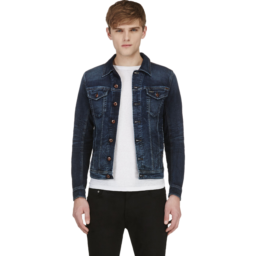

In [106]:
Image.fromarray(fashiongen_h5['input_image'][0])

In [107]:
fashiongen_h5['input_description'][0]

array([b'Denim-like jogg jacket in blue. Fading and whiskering throughout. Spread collar. Copper tone button closures at front. Flap pockets at chest with metallic logo plaque. Seam pockets at sides. Cinch tabs at back waistband. Single button sleeve cuffs. Tone on tone stitching.'],
      dtype='|S400')

In [108]:
fashiongen_h5['input_concat_description'][0]

array([b'Denim-like jogg jacket in blue. Fading and whiskering throughout. Spread collar. Copper tone button closures at front. Flap pockets at chest with metallic logo plaque. Seam pockets at sides. Cinch tabs at back waistband. Single button sleeve cuffs. Tone on tone stitching. Semi-sheer t-shirt in heather white. Crewneck collar. Patch pocket at breast. Tonal stitching.'],
      dtype='|S800')

In [109]:
fashiongen_h5['input_name'][0]

array([b'Blue Faded Elshar Jogg Jacket'], dtype='|S100')

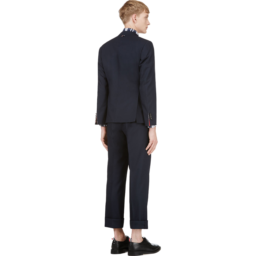

In [110]:
Image.fromarray(fashiongen_h5['input_image'][30])

In [111]:
fashiongen_h5['input_description'][30]

array([b"Long sleeve structured blazer in navy blue. Notched lapel collar with buttonhole. Two-button closure, breast pocket and flap pockets at front. Padded shoulders. Double vents at back hem. Welt pockets at interior. Fully lined. Tonal stitching. Four-button surgeon's cuffs.<br><br>Slim-fit pleated trousers in navy blue. Four-pocket styling. Cinch belt at back yoke. Serged ankle cuffs. Tonal stitching"],
      dtype='|S400')

In [112]:
fashiongen_h5['input_name'][30]

array([b'Navy Fine Wool Basic Body Suit'], dtype='|S100')

# Creating the test set

In [113]:
num_rows = len(fashiongen_h5['input_pose'])
rows = []
for h5_idx in tqdm(range(num_rows)):
    row = dict(
        h5_index=h5_idx,
        pose=fashiongen_h5['input_pose'][h5_idx][0].decode('utf-8'),
        product_id=fashiongen_h5['input_productID'][h5_idx][0]
    )
    rows.append(row)

  0%|          | 0/32528 [00:00<?, ?it/s]

In [114]:
df = pd.DataFrame(rows)

In [115]:
df

,h5_index,pose,product_id
0,0,id_gridfs_1,86605
1,1,id_gridfs_2,86605
2,2,id_gridfs_3,86605
3,3,id_gridfs_4,86605
4,4,id_gridfs_1,86773
...,...,...,...
32523,32523,id_gridfs_1,2938688
32524,32524,id_gridfs_2,2938688
32525,32525,id_gridfs_3,2938688
32526,32526,id_gridfs_4,2938688


In [116]:
test_set = df.groupby('product_id').first().head(2000).reset_index()

In [117]:
test_set

,product_id,h5_index,pose
0,86605,0,id_gridfs_1
1,86711,8,id_gridfs_1
2,86770,12,id_gridfs_1
3,86773,4,id_gridfs_1
4,86779,20,id_gridfs_1
...,...,...,...
1995,1284033,7993,id_gridfs_1
1996,1284123,8029,id_gridfs_1
1997,1284753,8060,id_gridfs_1
1998,1285133,7997,id_gridfs_1


In [119]:
root = Path('/net/acadia10a/data/zkhan/fashion-gen/')
save_path = root / 'test_images'
test_json = []
save_path.mkdir(exist_ok=True)
pairs_saved = 0
for row in tqdm(test_set.itertuples()):
    if pairs_saved >= 1000:
        break
    try:
        image = fashiongen_h5['input_image'][row.h5_index]
        image_as_pil = Image.fromarray(image)
        image_path = str(save_path / f'{row.h5_index}-{row.product_id}_{row.pose}.jpg')
        image_description = fashiongen_h5['input_description'][row.h5_index][0].decode('utf-8')
        image_name = fashiongen_h5['input_name'][row.h5_index][0].decode('utf-8')
        image_as_pil.save(image_path)
        test_json.append(
            {
                'image': f'test_images/{row.h5_index}-{row.product_id}_{row.pose}.jpg',
                'caption': [
                    image_name
                ]  
            }
        )
        pairs_saved +=1
    except UnicodeDecodeError:
        continue

0it [00:00, ?it/s]

In [120]:
with open(save_path / 'test_pairs.json', 'w') as f:
    json.dump(test_json, f)

# Creating the training set

In [128]:
fashiongen_h5 = h5py.File('/net/acadia10a/data/zkhan/fashion-gen/fashiongen_256_256_train.h5', mode='r')

In [129]:
num_images = len(fashiongen_h5['input_productID'])

In [130]:
root = Path('/net/acadia10a/data/zkhan/fashion-gen/')
save_path = root / 'train_images'
train_json = []
save_path.mkdir(exist_ok=True)
pairs_saved = 0
for idx in tqdm(range(num_images)):
    try:
        #image = fashiongen_h5['input_image'][idx]
        #image_as_pil = Image.fromarray(image)
        image_path = str(save_path / f'{idx}.jpg')
        image_description = fashiongen_h5['input_description'][idx][0].decode('utf-8')
        image_name = fashiongen_h5['input_name'][idx][0].decode('utf-8')
        #image_as_pil.save(image_path)
        train_json.extend(
            [
                           {
                'image': f'train_images/{idx}.jpg',
                'caption': image_name,  
            },
            {
                'image': f'train_images/{idx}.jpg',
                'caption': image_description
            } 
            ]
        )

        pairs_saved +=1
    except UnicodeDecodeError:
        continue
print(pairs_saved)

  0%|          | 0/260490 [00:00<?, ?it/s]

243899


In [125]:
Path(train_json[0]['image']).name

'0.jpg'

In [ ]:
with open('/net/acadia10a/data/zkhan/fashion-gen/')

In [132]:
# I fucked up earlier, fixing my mistake here.
for idx, pair in tqdm(enumerate(train_json)):
    train_json[idx]['image_id'] = f"fashiongen_{Path(pair['image']).stem}"

0it [00:00, ?it/s]

In [133]:
train_json[0]

{'image': 'train_images/0.jpg',
 'caption': 'Black Overdyed Sofier Denim Shirt',
 'image_id': 'fashiongen_0'}

In [134]:
with open(save_path / 'train_pairs.json', 'w') as f:
    json.dump(train_json, f)